In [1]:
############### Libraries #####################################
import seaborn as sns
import numpy as np
import pandas as pd
##############
import skbio

from collections import Counter
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from kpal.klib import Profile

######################
import skbio
from skbio.alignment import AlignmentStructure
from skbio.alignment import local_pairwise_align

import Bio
from Bio import Align 
from Bio import pairwise2
from Bio.SeqUtils.ProtParam import ProteinAnalysis
#import warnings
####################
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn import svm

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn import manifold

from sklearn.model_selection import train_test_split

from sklearn.utils.fixes import signature

################ decision boundary, libraries #########

from matplotlib.colors import ListedColormap


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs, make_checkerboard

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier)#, 
                              #ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

##########################
import matplotlib.pyplot as plt

%matplotlib inline

# Load data

In [2]:
##### load training dataset ######
data =  pd.read_csv('dataraning_new_data.csv', delimiter=',') #('training_data.csv', delimiter=',')
data.head()

,Unnamed: 0,Resp,VL.t0,CD4.t0,rtlength,pr_A,pr_C,pr_G,pr_R,pr_T,pr_Y,PR_GC,RT_A,RT_C,RT_G,RT_R,RT_T,RT_Y,RT_GC
0,1,0,4.3,145,1005,104,51,67,2,71,2,0.402730,402,167,210,1,1,1,0.378134
1,2,0,3.6,224,909,110,49,65,73,0,0,0.383838,355,151,193,1,3,203,0.381375
2,3,0,3.2,1017,903,105,47,67,2,74,2,0.389078,360,146,181,1,7,201,0.368243
3,4,0,5.7,206,1455,105,49,71,1,71,0,0.405405,586,245,305,1,1,317,0.378527
4,5,0,3.5,572,903,105,50,69,73,0,0,0.400673,353,150,184,2,5,1,0.374439


In [3]:
####### Number of missing data ########
nb_missing = data.isnull().sum().sum()
nb_missing

0

In [4]:
#### Check where we have (or which feature(s) have ) missing data
data.isnull().sum()


Unnamed: 0    0
Resp          0
VL.t0         0
CD4.t0        0
rtlength      0
pr_A          0
pr_C          0
pr_G          0
pr_R          0
pr_T          0
pr_Y          0
PR_GC         0
RT_A          0
RT_C          0
RT_G          0
RT_R          0
RT_T          0
RT_Y          0
RT_GC         0
dtype: int64

Text(0.5, 0, 'improve 1 or not 0')

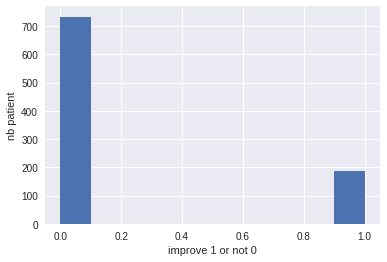

In [5]:
##############  Histogram of improving '1' of responds after 16 weeks of therapy #################
data['Resp'].hist()
plt.ylabel("nb patient")
plt.xlabel("improve 1 or not 0")

# We have imbalanced data

# Pre-Processing

### 1) Imbalanced data: solution

#### 1.1) With SMOTE

In [6]:
data_X = data[['VL.t0','CD4.t0', 'rtlength', 'pr_A', 'pr_C','pr_G', 'pr_R', 'pr_T','pr_Y','PR_GC','RT_A', 'RT_C', 
                  'RT_G', 'RT_R', 'RT_T', 'RT_Y', 'RT_GC']]
# data_X = data[['VL-t0', 'CD4-t0']]

In [7]:
sm = imblearn.over_sampling.SMOTE( sampling_strategy='auto', kind='regular', random_state=0 )
X_resampled1 , y_resampled1 = sm.fit_sample(data_X, data['Resp'])

In [8]:
print('Original dataset shape:', Counter(data['Resp']))
print('Resampled dataset shape:', Counter(y_resampled1))

Original dataset shape: Counter({0: 733, 1: 187})
Resampled dataset shape: Counter({0: 733, 1: 733})


Text(0.5, 1.0, 'VL-t0 histogram')

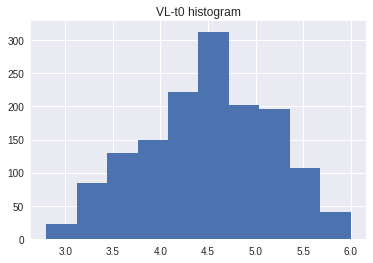

In [9]:
plt.hist(X_resampled1[:,0])
plt.title('VL-t0 histogram')

Text(0.5, 1.0, 'CD4-t0 histogram')

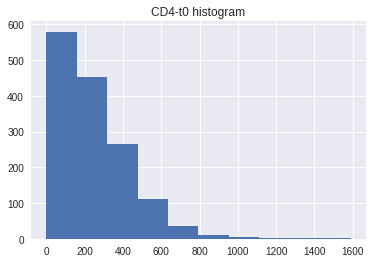

In [10]:
plt.hist(X_resampled1[:,1])
plt.title('CD4-t0 histogram')

#### 1.2) With SMOTENC (for sequence)

In [11]:
#cat_feats = [2,3]
#sm_enc = imblearn.over_sampling.SMOTENC(cat_feats, sampling_strategy='auto')
#X_resampled , y_resampled = sm_enc.fit_sample(data, data['Resp'])

In [12]:
#print('Original dataset shape:', Counter(data['Resp']))
#print('Resampled dataset shape:', Counter(y_resampled))

In [13]:
#plt.hist(X_resampled[:,0])

# I) Isomap Transformation

In [14]:
np.random.seed(5)

In [15]:
manifold_isomap = manifold.Isomap(n_neighbors=5, n_components=12, tol=0, max_iter=150, n_jobs=7)
#X_resampled1_isomap = manifold_isomap.fit_transform(X_resampled1)

#Isomap(n_neighbors=5, n_components=2, eigen_solver=’auto’, tol=0, max_iter=None, path_method=’auto’, 
#        neighbors_algorithm=’auto’, n_jobs=None)

## Split Data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled1, y_resampled1, test_size=.1, random_state =0)

## Transform

In [17]:
X_train = manifold_isomap.fit_transform(X_train)
X_test = manifold_isomap.transform(X_test)

## I.1) K-Nearest-Neighbors (KNN) Algorithm

In [18]:
# Clustering  with KNN classifier
modelknn = KNeighborsClassifier(n_neighbors=5, p=1, n_jobs=2)
modelknn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=2, n_neighbors=5, p=1,
           weights='uniform')

In [19]:
knn_accur = sklearn.model_selection.cross_val_score(modelknn, 
                                        X_train, y_train, 
                                        scoring='accuracy',cv=5)
print(knn_accur)
print(knn_accur.mean())

[0.70833333 0.74621212 0.72727273 0.75378788 0.72623574]
0.7323683604101855


In [20]:
modelknn_predict = modelknn.predict(X_test)

In [21]:
knn_accur_pred = metrics.accuracy_score(y_test, modelknn_predict)
print(knn_accur_pred)

0.7551020408163265


In [22]:
##### confusion matrix ######
conf_mat_knn = metrics.confusion_matrix(y_true=y_test , y_pred=modelknn_predict)
print('%%%%%%%%% Confusion Matrix: KNN %%%%%%%%%\n')
print(conf_mat_knn)


%%%%%%%%% Confusion Matrix: KNN %%%%%%%%%

[[56 22]
 [14 55]]


In [23]:
########## Classification Report ################
print('%%%%%%%%%%%%%% Classification Report: KNN %%%%%%%%%%%%% \n') 
print(metrics.classification_report(y_test, modelknn_predict))

%%%%%%%%%%%%%% Classification Report: KNN %%%%%%%%%%%%% 

              precision    recall  f1-score   support

           0       0.80      0.72      0.76        78
           1       0.71      0.80      0.75        69

   micro avg       0.76      0.76      0.76       147
   macro avg       0.76      0.76      0.76       147
weighted avg       0.76      0.76      0.76       147



#### Confusion Matrix

In [24]:
##### confusion matrix ######
conf_mat_knn = metrics.confusion_matrix(y_true=y_test , y_pred=modelknn_predict)
print('Confusion Matrix KNN: \n', conf_mat_knn)

Confusion Matrix KNN: 
 [[56 22]
 [14 55]]


In [25]:
#from sklearn.metrics import average_precision_score
average_precision_knn = metrics.average_precision_score(y_test, modelknn_predict)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_knn))

Average precision-recall score: 0.66


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.66')

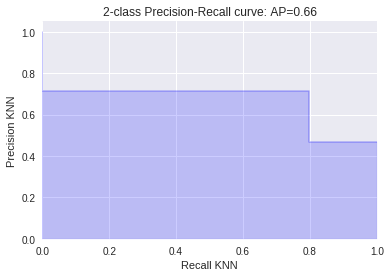

In [26]:
#from sklearn.metrics import precision_recall_curve
#import matplotlib.pyplot as plt


precision_knn, recall_knn, _ = metrics.precision_recall_curve(y_test, modelknn_predict)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall_knn, precision_knn, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_knn, precision_knn, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall KNN')
plt.ylabel('Precision KNN')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision_knn))

In [27]:
print(recall_knn)

[1.         0.79710145 0.        ]


## I.2) Random Forest Classifier

In [28]:
model_RandForest = RandomForestClassifier(bootstrap=True, max_depth=5, n_estimators=100, criterion="entropy",
                                          max_features='auto', class_weight="balanced")
model_RandForest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [29]:
model_RandForest_accur = sklearn.model_selection.cross_val_score(model_RandForest, 
                                        X_train, y_train, 
                                        scoring='accuracy',cv=3)

In [30]:
print(model_RandForest_accur)
print(model_RandForest_accur.mean())

[0.73469388 0.74715262 0.70842825]
0.730091581051555


In [31]:
model_RandForest_pred = model_RandForest.predict(X_test)
model_RandForest_accur_pred = metrics.accuracy_score(y_test, model_RandForest_pred)
print(model_RandForest_accur_pred)

0.7619047619047619


In [32]:
##### confusion matrix ######
conf_mat_RandForest = metrics.confusion_matrix(y_true=y_test , y_pred=model_RandForest_pred)
print('%%%%%%%%% Confusion Matrix: Random Forest %%%%%%%%%\n')
print(conf_mat_RandForest)


%%%%%%%%% Confusion Matrix: Random Forest %%%%%%%%%

[[63 15]
 [20 49]]


In [33]:
########## Classification Report ################
print('%%%%%%%%%%%%%% Classification Report: Random Forest %%%%%%%%%%%%% \n') 
print(metrics.classification_report(y_test, model_RandForest_pred))


%%%%%%%%%%%%%% Classification Report: Random Forest %%%%%%%%%%%%% 

              precision    recall  f1-score   support

           0       0.76      0.81      0.78        78
           1       0.77      0.71      0.74        69

   micro avg       0.76      0.76      0.76       147
   macro avg       0.76      0.76      0.76       147
weighted avg       0.76      0.76      0.76       147



## I.3) Decision Tree Classifier

In [34]:
model_decision_tree = DecisionTreeClassifier(max_depth=8, criterion='entropy')#, class_weight='balanced')
model_decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [35]:
model_decision_tree_accur = sklearn.model_selection.cross_val_score(model_decision_tree, 
                                        X_train, y_train, 
                                        scoring='accuracy',cv=5)
print(model_decision_tree_accur)
print(model_decision_tree_accur.mean())

[0.71590909 0.76136364 0.72348485 0.68560606 0.72623574]
0.7225198755617006


In [36]:
model_decision_tree_pred = model_decision_tree.predict(X_test)
model_decision_tree_accur_pred = metrics.accuracy_score(y_test, model_decision_tree_pred)
print(model_decision_tree_accur_pred)

0.7619047619047619


In [37]:
##### confusion matrix ######
conf_mat_decision_tree = metrics.confusion_matrix(y_true=y_test , y_pred=model_decision_tree_pred)
print('%%%%%%%%% Confusion Matrix: Decision Tree %%%%%%%%%\n')
print(conf_mat_decision_tree)


%%%%%%%%% Confusion Matrix: Decision Tree %%%%%%%%%

[[62 16]
 [19 50]]


In [38]:
########## Classification Report ################
print('%%%%%%%%%%%%%% Classification Report: Decision Tree %%%%%%%%%%%%% \n') 
print(metrics.classification_report(y_test, model_decision_tree_pred))

%%%%%%%%%%%%%% Classification Report: Decision Tree %%%%%%%%%%%%% 

              precision    recall  f1-score   support

           0       0.77      0.79      0.78        78
           1       0.76      0.72      0.74        69

   micro avg       0.76      0.76      0.76       147
   macro avg       0.76      0.76      0.76       147
weighted avg       0.76      0.76      0.76       147



## I.4) Logistic Regression

In [39]:
model_logistic_reg = LogisticRegression(C=0.01, solver='liblinear', multi_class='auto')
model_logistic_reg.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
model_logistReg_accur = sklearn.model_selection.cross_val_score(model_logistic_reg, 
                                        X_train, y_train, 
                                        scoring='accuracy',cv=5)
print(model_logistReg_accur)
print(model_logistReg_accur.mean())

[0.62121212 0.65909091 0.61742424 0.64772727 0.61977186]
0.6330452817144832


In [41]:
model_logistReg_pred = model_decision_tree.predict(X_test)
model_logistReg_accur_pred = metrics.accuracy_score(y_test, model_logistReg_pred)
print(model_logistReg_accur_pred)

0.7619047619047619


In [42]:
##### confusion matrix ######
conf_mat_logistReg = metrics.confusion_matrix(y_true=y_test , y_pred=model_logistReg_pred)
print('%%%%%%%%% Confusion Matrix: Logistic Regression %%%%%%%%%\n')
print(conf_mat_logistReg)


%%%%%%%%% Confusion Matrix: Logistic Regression %%%%%%%%%

[[62 16]
 [19 50]]


In [43]:
########## Classification Report ################
print('%%%%%%%%%%%%%% Classification Report: Logistic Regression %%%%%%%%%%%%% \n') 
print(metrics.classification_report(y_test, model_logistReg_pred))

%%%%%%%%%%%%%% Classification Report: Logistic Regression %%%%%%%%%%%%% 

              precision    recall  f1-score   support

           0       0.77      0.79      0.78        78
           1       0.76      0.72      0.74        69

   micro avg       0.76      0.76      0.76       147
   macro avg       0.76      0.76      0.76       147
weighted avg       0.76      0.76      0.76       147



## I.5) Gaussian Naives Bayesian

In [44]:
model_gaus_nb = GaussianNB()
model_gaus_nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [45]:
model_gaus_nb_accur = sklearn.model_selection.cross_val_score(model_gaus_nb, 
                                        X_train, y_train, 
                                        scoring='accuracy',cv=5)
print(model_gaus_nb_accur)
print(model_gaus_nb_accur.mean())

[0.625      0.61742424 0.60227273 0.64772727 0.54372624]
0.6072300956331375


In [46]:
model_gaus_nb_pred = model_gaus_nb.predict(X_test)
model_gaus_nb_accur_pred = metrics.accuracy_score(y_test, model_gaus_nb_pred)
print(model_gaus_nb_accur_pred)

0.6394557823129252


In [47]:
##### confusion matrix ######
conf_mat_gaus_nb = metrics.confusion_matrix(y_true=y_test , y_pred=model_gaus_nb_pred)
print('%%%%%%%%% Confusion Matrix: Gaussian Naives Bayesian %%%%%%%%%\n')
print(conf_mat_gaus_nb)


%%%%%%%%% Confusion Matrix: Gaussian Naives Bayesian %%%%%%%%%

[[48 30]
 [23 46]]


In [48]:
########## Classification Report ################
print('%%%%%%%%%%%%%% Classification Report: Gaussian Naives Bayesian %%%%%%%%%%%%% \n') 
print(metrics.classification_report(y_test, model_gaus_nb_pred))

%%%%%%%%%%%%%% Classification Report: Gaussian Naives Bayesian %%%%%%%%%%%%% 

              precision    recall  f1-score   support

           0       0.68      0.62      0.64        78
           1       0.61      0.67      0.63        69

   micro avg       0.64      0.64      0.64       147
   macro avg       0.64      0.64      0.64       147
weighted avg       0.64      0.64      0.64       147



## I.6) XGBoost Classifier

In [49]:
model_xgbc = XGBClassifier(learning_rate=0.5, reg_lambda=0.1, n_jobs=7)
model_xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=7, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [50]:
model_xgbc_accur = sklearn.model_selection.cross_val_score(model_xgbc, 
                                        X_train, y_train, 
                                        scoring='accuracy',cv=5)
print(model_xgbc_accur)
print(model_xgbc_accur.mean())

[0.72348485 0.77651515 0.77651515 0.78030303 0.74144487]
0.7596526097476668


In [51]:
model_xgbc_pred = model_xgbc.predict(X_test)
model_xgbc_accur_pred = metrics.accuracy_score(y_test, model_xgbc_pred)
print(model_xgbc_accur_pred)

0.7551020408163265


In [52]:
##### confusion matrix ######
conf_mat_xgbc = metrics.confusion_matrix(y_true=y_test , y_pred=model_xgbc_pred)
print('%%%%%%%%% Confusion Matrix: XGBoost Classifier %%%%%%%%%\n')
print(conf_mat_xgbc)


%%%%%%%%% Confusion Matrix: XGBoost Classifier %%%%%%%%%

[[60 18]
 [18 51]]


In [53]:
########## Classification Report ################
print('%%%%%%%%%%%%%% Classification Report: XGBoost Classifier %%%%%%%%%%%%% \n') 
print(metrics.classification_report(y_test, model_xgbc_pred))

%%%%%%%%%%%%%% Classification Report: XGBoost Classifier %%%%%%%%%%%%% 

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        78
           1       0.74      0.74      0.74        69

   micro avg       0.76      0.76      0.76       147
   macro avg       0.75      0.75      0.75       147
weighted avg       0.76      0.76      0.76       147



## I.7) KMeans

In [54]:
modelkmeans = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=150) #'random', max_iter=100, n_init=80)
modelkmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=150, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [55]:
modelkmeans_accur = sklearn.model_selection.cross_val_score(modelkmeans, 
                                        X_train, y_train, 
                                        scoring='accuracy',cv=5)
print(modelkmeans_accur)
print(modelkmeans_accur.mean())

[0.49621212 0.46212121 0.47348485 0.5530303  0.57794677]
0.5125590505818642


In [56]:
modelkmeans_pred = modelkmeans.predict(X_test)
modelkmeans_accur_pred = metrics.accuracy_score(y_test, modelkmeans_pred)
print(modelkmeans_accur_pred)

0.4557823129251701


In [57]:
##### confusion matrix ######
conf_mat_kmeans = metrics.confusion_matrix(y_true=y_test , y_pred=modelkmeans_pred)
print('%%%%%%%%% Confusion Matrix: KMeans %%%%%%%%%\n')
print(conf_mat_kmeans)


%%%%%%%%% Confusion Matrix: KMeans %%%%%%%%%

[[18 60]
 [20 49]]


In [58]:
########## Classification Report ################
print('%%%%%%%%%%%%%% Classification Report: KMeans %%%%%%%%%%%%% \n') 
print(metrics.classification_report(y_test, modelkmeans_pred))


%%%%%%%%%%%%%% Classification Report: KMeans %%%%%%%%%%%%% 

              precision    recall  f1-score   support

           0       0.47      0.23      0.31        78
           1       0.45      0.71      0.55        69

   micro avg       0.46      0.46      0.46       147
   macro avg       0.46      0.47      0.43       147
weighted avg       0.46      0.46      0.42       147



## I.8) SVC

In [59]:
model_svc = svm.SVC(gamma='scale',class_weight= "balanced")
model_svc.fit(X_train, y_train)  

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [60]:
model_svc_accur = sklearn.model_selection.cross_val_score(model_svc, 
                                        X_train, y_train, 
                                        scoring='accuracy',cv=5)
print(model_svc_accur)
print(model_svc_accur.mean())

[0.73106061 0.78787879 0.79924242 0.77272727 0.74524715]
0.7672312478396128


In [61]:
model_svc_pred = model_svc.predict(X_test)
model_svc_accur_pred = metrics.accuracy_score(y_test, model_svc_pred)
print(model_svc_accur_pred)

0.782312925170068


In [62]:
##### confusion matrix ######
conf_mat_svc = metrics.confusion_matrix(y_true=y_test , y_pred=model_svc_pred)
print('%%%%%%%%% Confusion Matrix: SVC %%%%%%%%%\n')
print(conf_mat_svc)


%%%%%%%%% Confusion Matrix: SVC %%%%%%%%%

[[63 15]
 [17 52]]


In [63]:
########## Classification Report ################
print('%%%%%%%%%%%%%% Classification Report: SVC %%%%%%%%%%%%% \n') 
print(metrics.classification_report(y_test, model_svc_pred))

%%%%%%%%%%%%%% Classification Report: SVC %%%%%%%%%%%%% 

              precision    recall  f1-score   support

           0       0.79      0.81      0.80        78
           1       0.78      0.75      0.76        69

   micro avg       0.78      0.78      0.78       147
   macro avg       0.78      0.78      0.78       147
weighted avg       0.78      0.78      0.78       147



## I.9) Structural SVM